# Prototype debugger

In [52]:
# Imports
import pandas as pd
from binance.client import Client
from binance.enums import * #https://github.com/sammchardy/python-binance/blob/master/binance/enums.py
import datetime
import json
import math

import schedule
import time
from datetime import datetime, timedelta
from joblib import dump, load

import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from IPython.display import clear_output

def get_api_keys(site: str, api_type: str)->str:
    """
    gets api keys stored in api-keys/api-keys.txt
    site: 'binance'
    api_type: 'api', 'secret'
    """
    with open('../api-keys/api-keys.txt') as json_file:
        return json.load(json_file)[site][api_type]
# Constants
api_key = get_api_keys("binance", "api")
api_secret = get_api_keys("binance", "secret")

client = Client(api_key=api_key, api_secret=api_secret)

In [53]:
def get_margin_asset(name:str):
    """returns a dictionary with:
    - asset name
    - free
    - locked
    - borrowed
    - interest
    - netAsset"""
    return list(filter(lambda x: x['asset'] == name, client.get_margin_account()["userAssets"]))[0]

In [33]:
client.transfer_spot_to_isolated_margin(asset='USDT', symbol='CELRUSDT', amount='0.13')

{'tranId': 69737862700, 'clientTag': ''}

In [57]:
c = client.get_isolated_margin_account()

In [58]:
c

{'assets': [{'baseAsset': {'asset': 'CELR',
    'borrowEnabled': True,
    'borrowed': '0',
    'free': '0',
    'interest': '0',
    'locked': '0',
    'netAsset': '0',
    'netAssetOfBtc': '0',
    'repayEnabled': True,
    'totalAsset': '0'},
   'quoteAsset': {'asset': 'USDT',
    'borrowEnabled': True,
    'borrowed': '0',
    'free': '17.7133',
    'interest': '0',
    'locked': '0',
    'netAsset': '17.7133',
    'netAssetOfBtc': '0.00055744',
    'repayEnabled': True,
    'totalAsset': '17.7133'},
   'symbol': 'CELRUSDT',
   'isolatedCreated': True,
   'marginLevel': '999',
   'marginLevelStatus': 'EXCESSIVE',
   'marginRatio': '5',
   'indexPrice': '0.02371997',
   'liquidatePrice': '0',
   'liquidateRate': '0',
   'tradeEnabled': True},
  {'baseAsset': {'asset': 'FET',
    'borrowEnabled': True,
    'borrowed': '0',
    'free': '0',
    'interest': '0',
    'locked': '0',
    'netAsset': '0',
    'netAssetOfBtc': '0',
    'repayEnabled': True,
    'totalAsset': '0'},
   'quote

In [28]:
def get_isolated_margin_account(base_asset: str):
    """Returns dict for isolated margin account for base_asset. Enter base_asset as 'FET'. Do NOT include USDT"""
    c = client.get_isolated_margin_account()
    return list(filter(lambda x: x["baseAsset"]["asset"] == base_asset, c["assets"]))[0]

In [39]:
a = get_isolated_margin_account("FET")

In [51]:
a['marginLevel']

'999'

In [49]:
for item in a["baseAsset"]:
    if item in ["asset", "borrowed", "free", "interest", "netAsset"]:
        print(f"{item}: {a['baseAsset'][item]}")
for item in a["quoteAsset"]:
    if item in ["asset", "borrowed", "free", "interest", "netAsset"]:
        print(f"{item}: {a['quoteAsset'][item]}")

asset: FET
borrowed: 0
free: 0
interest: 0
netAsset: 0
asset: USDT
borrowed: 0
free: 0.07
interest: 0
netAsset: 0.07


In [37]:
float(get_isolated_margin_account("CELR")["quoteAsset"]["free"])

0.06

In [26]:
client.transfer_isolated_margin_to_spot(asset='USDT', symbol='CELRUSDT', amount='0.13')

{'tranId': 69727232518, 'clientTag': ''}

In [15]:
client.get_margin_trades(symbol='XMRUSDT')[-1]["isBuyer"] == False

True

In [3]:
get_margin_asset("USDT")

{'asset': 'USDT',
 'free': '36.63503488',
 'locked': '0',
 'borrowed': '0',
 'interest': '0',
 'netAsset': '36.63503488'}

In [4]:
get_margin_asset("ZEC")

{'asset': 'ZEC',
 'free': '0.1814078',
 'locked': '0',
 'borrowed': '0',
 'interest': '0',
 'netAsset': '0.1814078'}

In [5]:
get_margin_asset("XMR")

{'asset': 'XMR',
 'free': '0.00000835',
 'locked': '0',
 'borrowed': '0.09252',
 'interest': '0.00001545',
 'netAsset': '-0.0925271'}

In [55]:
df1 = pd.read_csv("../data/ZECUSDT-past.csv")
df2 = pd.read_csv("../data/XMRUSDT-past.csv")
df1.set_index("timestamp", inplace=True)
df2.set_index("timestamp", inplace=True)

In [58]:
df = df1.open.rename("A").to_frame()
df["B"] = df2.open
# df["C"] = df3.close

In [59]:
df = df[4000:]
df = df.dropna()

In [60]:
df

,A,B
timestamp,,
1553380800000,56.41,52.37
1553380860000,56.41,52.37
1553380920000,56.41,52.37
1553380980000,56.41,52.37
1553381040000,56.41,52.37
...,...,...
1626327660000,102.01,197.83
1626327720000,102.04,197.70
1626327780000,102.09,197.82


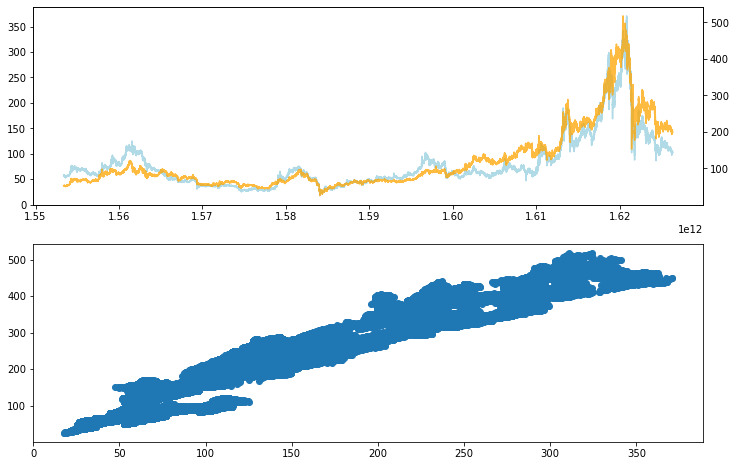

In [61]:
fig, (ax, ax1) = plt.subplots(2, figsize=(12, 8))
ax.plot(df[df.columns[0]], color="lightblue", alpha=.95)
axi = ax.twinx()
axi.plot(df[df.columns[1]], color="orange", alpha=.75)
ax1.scatter(df[df.columns[0]], df[df.columns[1]]);

In [47]:
results = sm.ols(formula="B ~ A", data=df[['B', 'A']]).fit()
print(results.params)
hedgeRatio = results.params[1]
print('hedgeRatio=%f' % hedgeRatio)

Intercept   -3.409302
A            1.535786
dtype: float64
hedgeRatio=1.535786


<AxesSubplot:xlabel='timestamp'>

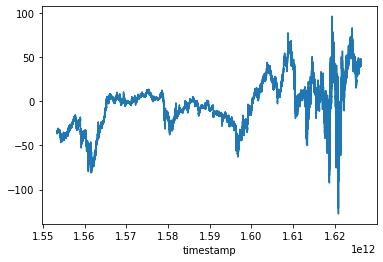

In [48]:
spread = pd.Series((df['B'] - hedgeRatio * df['A'])).rename("spread").to_frame()
spread["mean"] = spread.spread.rolling(2000).mean()
spread["std"] =  spread.spread.rolling(2000).std()
spread["zscore"] = pd.Series((spread["spread"]-spread["mean"])/spread["std"])
spread.spread.plot()

<AxesSubplot:xlabel='timestamp'>

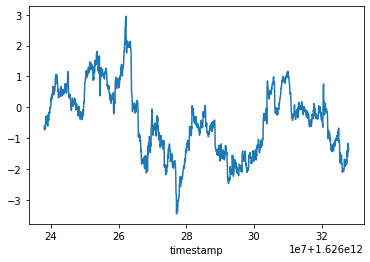

In [49]:
spread["zscore"][-1500:].plot()